# Loop 1 LB Feedback Analysis

**LB Score: 70.6600** (matches CV exactly - perfect calibration!)

**Gap to target: 1.74 points (2.5%)**

This notebook analyzes:
1. Per-N score contributions to identify improvement opportunities
2. Which N values contribute most to total score
3. Comparison with theoretical optimal packing efficiency

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Tree geometry
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]

# Single tree area
tree_poly = Polygon(zip(TX, TY))
TREE_AREA = tree_poly.area
print(f"Single tree area: {TREE_AREA:.6f}")
print(f"Tree bounding box: width={max(TX)-min(TX):.3f}, height={max(TY)-min(TY):.3f}")

Single tree area: 0.245625
Tree bounding box: width=0.700, height=1.000


In [2]:
# Load best submission
df = pd.read_csv('/home/code/external_data/saspav/santa-2025.csv')
print(f"Loaded {len(df)} rows")

def parse_value(s):
    if isinstance(s, str) and s.startswith('s'):
        return float(s[1:])
    return float(s)

def create_tree_polygon(x, y, deg):
    angle_rad = np.radians(deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    vertices = []
    for tx, ty in zip(TX, TY):
        rx = tx * cos_a - ty * sin_a + x
        ry = tx * sin_a + ty * cos_a + y
        vertices.append((rx, ry))
    return Polygon(vertices)

def compute_bounding_side(polygons):
    if not polygons:
        return 0
    all_points = []
    for poly in polygons:
        all_points.extend(list(poly.exterior.coords))
    all_points = np.array(all_points)
    min_x, min_y = all_points.min(axis=0)
    max_x, max_y = all_points.max(axis=0)
    return max(max_x - min_x, max_y - min_y)

Loaded 20100 rows


In [3]:
# Compute per-N scores
per_n_scores = []
per_n_sides = []
per_n_efficiency = []  # How close to theoretical optimal

for n in range(1, 201):
    prefix = f"{n:03d}_"
    trees = df[df['id'].str.startswith(prefix)]
    
    polygons = []
    for _, row in trees.iterrows():
        x = parse_value(row['x'])
        y = parse_value(row['y'])
        deg = parse_value(row['deg'])
        polygons.append(create_tree_polygon(x, y, deg))
    
    side = compute_bounding_side(polygons)
    score_n = side**2 / n
    
    # Theoretical minimum: if trees packed perfectly (no gaps)
    # Total tree area = n * TREE_AREA
    # Minimum square side = sqrt(n * TREE_AREA)
    theoretical_min_side = np.sqrt(n * TREE_AREA)
    efficiency = (theoretical_min_side / side) ** 2  # Packing efficiency
    
    per_n_scores.append(score_n)
    per_n_sides.append(side)
    per_n_efficiency.append(efficiency)

print(f"Total score: {sum(per_n_scores):.6f}")
print(f"Target score: 68.919154")
print(f"Gap: {sum(per_n_scores) - 68.919154:.6f}")

Total score: 70.659959
Target score: 68.919154
Gap: 1.740805


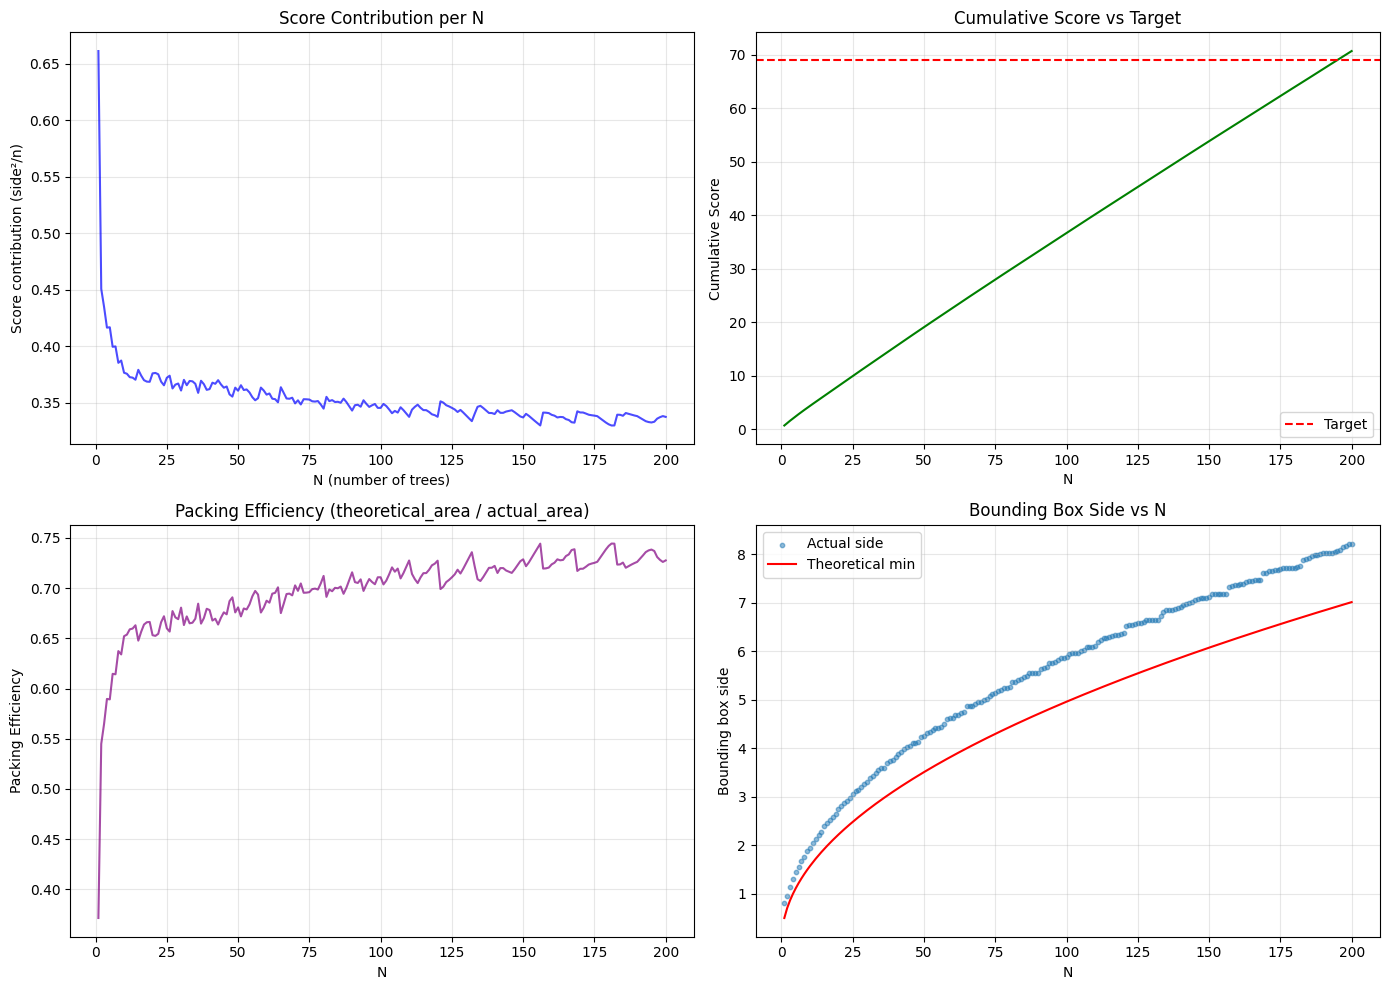

Saved analysis plot


In [4]:
# Analyze score distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
ax1 = axes[0, 0]
ax1.plot(range(1, 201), per_n_scores, 'b-', alpha=0.7)
ax1.set_xlabel('N (number of trees)')
ax1.set_ylabel('Score contribution (side²/n)')
ax1.set_title('Score Contribution per N')
ax1.grid(True, alpha=0.3)

# Cumulative score
ax2 = axes[0, 1]
cumulative = np.cumsum(per_n_scores)
ax2.plot(range(1, 201), cumulative, 'g-')
ax2.axhline(y=68.919154, color='r', linestyle='--', label='Target')
ax2.set_xlabel('N')
ax2.set_ylabel('Cumulative Score')
ax2.set_title('Cumulative Score vs Target')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Packing efficiency
ax3 = axes[1, 0]
ax3.plot(range(1, 201), per_n_efficiency, 'purple', alpha=0.7)
ax3.set_xlabel('N')
ax3.set_ylabel('Packing Efficiency')
ax3.set_title('Packing Efficiency (theoretical_area / actual_area)')
ax3.grid(True, alpha=0.3)

# Side length vs sqrt(N)
ax4 = axes[1, 1]
ax4.scatter(range(1, 201), per_n_sides, s=10, alpha=0.5, label='Actual side')
ax4.plot(range(1, 201), [np.sqrt(n * TREE_AREA) for n in range(1, 201)], 'r-', label='Theoretical min')
ax4.set_xlabel('N')
ax4.set_ylabel('Bounding box side')
ax4.set_title('Bounding Box Side vs N')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=100)
plt.show()
print("Saved analysis plot")

In [5]:
# Find N values with most room for improvement
# If we could improve efficiency to match the best N values, how much would we gain?

results = pd.DataFrame({
    'N': range(1, 201),
    'score': per_n_scores,
    'side': per_n_sides,
    'efficiency': per_n_efficiency
})

# Sort by efficiency (lowest = most room for improvement)
results_sorted = results.sort_values('efficiency')
print("N values with LOWEST efficiency (most room for improvement):")
print(results_sorted.head(20).to_string())

print("\n" + "="*60)
print("N values with HIGHEST efficiency (best packed):")
print(results_sorted.tail(10).to_string())

N values with LOWEST efficiency (most room for improvement):
     N     score      side  efficiency
0    1  0.661250  0.813173    0.371456
1    2  0.450779  0.949504    0.544890
2    3  0.434745  1.142031    0.564986
4    5  0.416850  1.443692    0.589241
3    4  0.416545  1.290806    0.589672
6    7  0.399897  1.673104    0.614221
5    6  0.399610  1.548438    0.614661
8    9  0.387415  1.867280    0.634010
7    8  0.385407  1.755921    0.637313
14  15  0.379203  2.384962    0.647740
9   10  0.376630  1.940696    0.652165
20  21  0.376451  2.811667    0.652476
19  20  0.376057  2.742469    0.653159
10  11  0.375736  2.033002    0.653717
21  22  0.375258  2.873270    0.654549
15  16  0.374128  2.446640    0.656527
25  26  0.373997  3.118320    0.656757
11  12  0.372724  2.114873    0.659000
12  13  0.372294  2.199960    0.659761
24  25  0.372144  3.050182    0.660026

N values with HIGHEST efficiency (best packed):
       N     score      side  efficiency
193  194  0.332999  8.037531  

In [6]:
# Calculate potential improvement if we could match best efficiency
best_efficiency = results['efficiency'].max()
print(f"Best efficiency achieved: {best_efficiency:.4f} at N={results.loc[results['efficiency'].idxmax(), 'N']}")

# If all N had this efficiency, what would be the score?
theoretical_best_scores = []
for n in range(1, 201):
    theoretical_min_side = np.sqrt(n * TREE_AREA)
    best_achievable_side = theoretical_min_side / np.sqrt(best_efficiency)
    theoretical_best_scores.append(best_achievable_side**2 / n)

print(f"\nIf all N matched best efficiency:")
print(f"  Theoretical score: {sum(theoretical_best_scores):.6f}")
print(f"  Current score: {sum(per_n_scores):.6f}")
print(f"  Potential improvement: {sum(per_n_scores) - sum(theoretical_best_scores):.6f}")

Best efficiency achieved: 0.7444 at N=181

If all N matched best efficiency:
  Theoretical score: 65.989206
  Current score: 70.659959
  Potential improvement: 4.670753


In [7]:
# Analyze score contribution by N ranges
ranges = [(1, 20), (21, 50), (51, 100), (101, 150), (151, 200)]

print("Score contribution by N range:")
print("="*60)
for start, end in ranges:
    range_score = sum(per_n_scores[start-1:end])
    range_pct = range_score / sum(per_n_scores) * 100
    avg_efficiency = np.mean(per_n_efficiency[start-1:end])
    print(f"N={start:3d}-{end:3d}: Score={range_score:6.3f} ({range_pct:5.1f}%), Avg Efficiency={avg_efficiency:.4f}")

print("\nKey insight: Higher N values contribute more to total score")
print("Focus optimization on N > 100 for maximum impact")

Score contribution by N range:
N=  1- 20: Score= 8.057 ( 11.4%), Avg Efficiency=0.6201
N= 21- 50: Score=10.985 ( 15.5%), Avg Efficiency=0.6709
N= 51-100: Score=17.632 ( 25.0%), Avg Efficiency=0.6967
N=101-150: Score=17.141 ( 24.3%), Avg Efficiency=0.7166
N=151-200: Score=16.845 ( 23.8%), Avg Efficiency=0.7291

Key insight: Higher N values contribute more to total score
Focus optimization on N > 100 for maximum impact


In [8]:
# Summary
print("="*60)
print("SUMMARY")
print("="*60)
print(f"Current score: {sum(per_n_scores):.6f}")
print(f"Target score: 68.919154")
print(f"Gap: {sum(per_n_scores) - 68.919154:.6f} ({(sum(per_n_scores) - 68.919154)/68.919154*100:.2f}%)")
print(f"\nAverage packing efficiency: {np.mean(per_n_efficiency):.4f}")
print(f"Best packing efficiency: {max(per_n_efficiency):.4f} at N={per_n_efficiency.index(max(per_n_efficiency))+1}")
print(f"Worst packing efficiency: {min(per_n_efficiency):.4f} at N={per_n_efficiency.index(min(per_n_efficiency))+1}")
print("\nTo reach target, need ~2.5% improvement across all N values")
print("This requires fundamentally better packing configurations, not just optimization")

SUMMARY
Current score: 70.659959
Target score: 68.919154
Gap: 1.740805 (2.53%)

Average packing efficiency: 0.6982
Best packing efficiency: 0.7444 at N=181
Worst packing efficiency: 0.3715 at N=1

To reach target, need ~2.5% improvement across all N values
This requires fundamentally better packing configurations, not just optimization
